# Scope of Notebook

This notebook allows you to plug in your featuried dataset from the previous week into an ml model, in this case we use random forest.  You will then be able to store the trained model in mlflow and calculate performance characteristics around the model like AUC and accuracy.  The advanced section of this notebook outlines how to retrieve the best set of hyperparameters to certify a model for production use.

![ml-model-train](../media/CMLE-Notebooks-Week3-Workflow.png)

# Setup

This notebook requires some configuration data to properly authenticate to your Adobe Experience Platform instance. You should be able to find all the values required above by following the Setup section of the **README**.

The next cell will be looking for your configuration file under your **ADOBE_HOME** path to fetch the values used throughout this notebook. See more details in the Setup section of the **README** to understand how to create your configuration file.

In [0]:
import os
from configparser import ConfigParser
  
config = ConfigParser()
config_path = os.path.join(os.environ["ADOBE_HOME"], "conf", "config.ini")
if not os.path.exists(config_path):
  raise Exception(f"Looking for configuration under {config_path} but config not found, please verify path")
config.read(config_path)
  
ims_org_id = config.get("Platform", "ims_org_id")
sandbox_name = config.get("Platform", "sandbox_name")
environment = config.get("Platform", "environment")
client_id = config.get("Authentication", "client_id")
client_secret = config.get("Authentication", "client_secret")
scopes=config.get("Authentication", "scopes")
dataset_id = config.get("Platform", "dataset_id")
featurized_dataset_id = config.get("Platform", "featurized_dataset_id")
export_path = config.get("Cloud", "export_path")
import_path = config.get("Cloud", "import_path")
data_format = config.get("Cloud", "data_format")
compression_type = config.get("Cloud", "compression_type")
model_name = config.get("Cloud", "model_name")

In [0]:
import re

username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().userName().get()
unique_id = s = re.sub("[^0-9a-zA-Z]+", "_", username)

print(f"Username: {username}")
print(f"Unique ID: {unique_id}")

Username: cmenguy@adobe.com
Unique ID: cmenguy_adobe_com


Before we run anything, make sure to install the following required libraries for this notebook. They are all publicly available libraries and the latest version should work fine.

In [0]:
!pip install aepp
!pip install adlfs
!pip install s3fs
!pip install fsspec

     |████████████████████████████████| 120 kB 10.9 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-ba66f562-f854-4b23-9191-cf0cc1b7ed77/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 61 kB 333 kB/s 
     |████████████████████████████████| 387 kB 23.2 MB/s 
     |████████████████████████████████| 1.0 MB 66.5 MB/s 
     |████████████████████████████████| 135 kB 94.6 MB/s 
     |████████████████████████████████| 158 kB 91.9 MB/s 
     |████████████████████████████████| 264 kB 97.2 MB/s 
     |████████████████████████████████| 114 kB 92.4 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 89 kB 9.5 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-ba66f562-f854-4b23-9191-cf0cc1b7ed77/bin/python -m pip install --upgrade pip' command.


Before any calls can take place, we need to configure the library and setup authentication credentials. For this you'll need the following piece of information. For information about how you can get these, please refer to the `Setup` section of the **Readme**:
- Client ID
- Client secret
- Private key
- Technical account ID

The private key needs to be accessible on disk from this notebook. We recommend uploading it to DBFS and refering to it with the `/dbfs` prefix. This can be achieved by clicking in the Databricks notebook interface on `File > Upload data to DBFS` and then selecting the **private.key** file you downloaded during the setup, click `Next` and then you should have the option to copy the path. Make sure it starts with `/dbfs/FileStore` - for example if you uploaded your private key into `/FileStore/shared_upload/your_username` then the final path should be `/dbfs/FileStore/shared_uploads/your_username/private.key`. Copy that value into the cell `Private Key Path` at the very top of this notebook.

In [0]:
import aepp

aepp.configure(
  environment=environment,
  sandbox=sandbox_name,
  org_id=ims_org_id,
  scopes=scopes, 
  secret=client_secret,
  client_id=client_id
)

# 1. Running a model on AEP data

In the previous week we generated our featurized data in the Data Landing Zone under the `dlz-destination` container. We can now read it so we can use it to train our ML model. Because this data can be pretty big, we want to first read it via a Spark dataframe, so we can then use a sample of it for training.

The featurized data exported into the Data Landing Zone is under the format **cmle/egress/$DATASETID/exportTime=$EXPORTTIME**. We know the dataset ID which is in your config under `featurized_dataset_id` so we're just missing the export time so we know what to read. To get that we can simply list files in the DLZ and find what the value is. The first step is to retrieve the credentials for the DLZ related to the destination container:

In [0]:
from aepp import flowservice

flow_conn = flowservice.FlowService()
credentials = flow_conn.getLandingZoneCredential(dlz_type='dlz_destination')

Now we use some Python libraries to authenticate and issue listing commands so we can get the paths and extract the time from it.

In [0]:
import fsspec
from fsspec import AbstractFileSystem

def getDLZFSPath(credentials: dict):
    if 'dlzProvider' in credentials.keys() and 'Amazon' in credentials['dlzProvider']:
        aws_credentials = {
            'key' : credentials['credentials']['awsAccessKeyId'],
            'secret' : credentials['credentials']['awsSecretAccessKey'],
            'token' : credentials['credentials']['awsSessionToken']
        }
        return fsspec.filesystem('s3', **aws_credentials), credentials['dlzPath']['bucketName'] + "/" + credentials['dlzPath']['dlzFolder']
    else:
        abs_credentials = {
            'account_name' : credentials['storageAccountName'],
            'sas_token' : credentials['SASToken']
        }
        return fsspec.filesystem('abfss', **abs_credentials), credentials['containerName']


def get_export_time(fs: AbstractFileSystem, container_name: str, base_path: str, dataset_id: str):
  featurized_data_base_path = f"{container_name}/{base_path}/{dataset_id}"
  featurized_data_export_paths = fs.ls(featurized_data_base_path)
  
  if len(featurized_data_export_paths) == 0:
    raise Exception(f"Found no exports for featurized data from dataset ID {dataset_id} under path {featurized_data_base_path}")
  elif len(featurized_data_export_paths) > 1:
    print(f"Found {len(featurized_data_export_paths)} exports from dataset dataset ID {dataset_id} under path {featurized_data_base_path}, using most recent one")
  
  featurized_data_export_path = featurized_data_export_paths[-1]
  featurized_data_export_time = featurized_data_export_path.strip().split("/")[-1].split("=")[-1]
  return featurized_data_export_time


fs, container = getDLZFSPath(credentials)


export_time = get_export_time(fs, container, export_path, featurized_dataset_id)
print(f"Using featurized data export time of {export_time}")

Using featurized data export time of 20230401140556


In [ ]:
At that point we're ready to read this data. We're using Spark since it could be pretty large as we're not doing any sampling. 
Based on the provisioned account Landing Zone could be either configured to use azure or aws, 
in case of azure following properties will be used to authenticate using SAS:
- `fs.azure.account.auth.type.$ACCOUNT.dfs.core.windows.net` should be set to `SAS`.
- `fs.azure.sas.token.provider.type.$ACCOUNT.dfs.core.windows.net` should be set to `org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider`.
- `fs.azure.sas.fixed.token.$ACCOUNT.dfs.core.windows.net` should be set to the SAS token retrieved earlier.

in case of aws following properties will be used to access data stored in s3:
- `fs.s3a.access.key` and `spark.hadoop.fs.s3a.access.key` should be the s3 access key
- `fs.s3a.secret.key` and `spark.hadoop.fs.s3a.secret.key` should be the s3 secret
- `fs.s3a.session.token` and `spark.hadoop.fs.s3a.session.token` should be set to s3 session token
- `fs.s3a.aws.credentials.provider` and `spark.hadoop.fs.s3a.aws.credentials.provider` should be set to `org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider`
- `fs.s3.impl` and `spark.hadoop.fs.s3.impl` should be set to `org.apache.hadoop.fs.s3a.S3AFileSystem`


The above properties are calculated based on the landing zone credentials, following util method will set these up:

In [ ]:
def configureSparkSessionAndGetPath(credentials):
    if 'dlzProvider' in credentials.keys() and 'Amazon' in credentials['dlzProvider']:
        aws_key = credentials['credentials']['awsAccessKeyId']
        aws_secret = credentials['credentials']['awsSecretAccessKey']
        aws_token = credentials['credentials']['awsSessionToken']
        aws_buket = credentials['dlzPath']['bucketName']
        dlz_folder = credentials['dlzPath']['dlzFolder']
        spark.conf.set("fs.s3a.access.key", aws_key)
        spark.conf.set("fs.s3a.secret.key", aws_secret)
        spark.conf.set("fs.s3a.session.token", aws_token)
        spark.conf.set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider")
        spark.conf.set("fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
        spark.conf.set("spark.hadoop.fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
        spark.conf.set("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.TemporaryAWSCredentialsProvider")
        spark.conf.set("spark.hadoop.fs.s3a.access.key", aws_key)
        spark.conf.set("spark.hadoop.fs.s3a.secret.key", aws_secret)
        spark.conf.set("fs.s3a.session.token", aws_token)
        return f"s3a://{aws_buket}/{dlz_folder}/"
    else:
        dlz_storage_account = credentials['storageAccountName']
        dlz_sas_token = credentials['SASToken']
        dlz_container = credentials['containerName']
        spark.conf.set(f"fs.azure.account.auth.type.{dlz_storage_account}.dfs.core.windows.net", "SAS")
        spark.conf.set(f"fs.azure.sas.token.provider.type.{dlz_storage_account}.dfs.core.windows.net", "org.apache.hadoop.fs.azurebfs.sas.FixedSASTokenProvider")
        spark.conf.set(f"fs.azure.sas.fixed.token.{dlz_storage_account}.dfs.core.windows.net", dlz_sas_token)
        return f"abfss://{dlz_container}@{dlz_storage_account}.dfs.core.windows.net/"

    

In [0]:
# init spark session for provisioned DLZ and get the base path (fs3://bucket_name/folder or abfss://container@account/)
cloud_base_path = configureSparkSessionAndGetPath(credentials)

input_path = cloud_base_path + f"{export_path}/{featurized_dataset_id}/exportTime={export_time}/"

#Let's put that in practice and create a Spark dataframe containing the entire featurized data:
df = spark.read.parquet(input_path)
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- eventType: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- subscriptionOccurred: long (nullable = true)
 |-- emailsReceived: long (nullable = true)
 |-- emailsOpened: long (nullable = true)
 |-- emailsClicked: long (nullable = true)
 |-- productsViewed: long (nullable = true)
 |-- propositionInteracts: long (nullable = true)
 |-- propositionDismissed: long (nullable = true)
 |-- webLinkClicks: long (nullable = true)
 |-- minutes_since_emailSent: integer (nullable = true)
 |-- minutes_since_emailOpened: integer (nullable = true)
 |-- minutes_since_emailClick: integer (nullable = true)
 |-- minutes_since_productView: integer (nullable = true)
 |-- minutes_since_propositionInteract: integer (nullable = true)
 |-- minutes_since_propositionDismiss: integer (nullable = true)
 |-- minutes_since_linkClick: integer (nullable = true)
 |-- random_row_number_for_user: integer (nullable = true)



We can then sample it to keep only a portion of the data for training before we bring the data in memory for use in the `scikit-learn` library. Here we're just going to use a sampling ratio of 50%, but you are welcome to use a bigger or smaller ratio. We use sampling **without** replacement to ensure the same profiles don't get picked up multiple times.

In [0]:
sampling_ratio = 0.5
df = df.sample(withReplacement=False, fraction=sampling_ratio)

## 1.1 Creating baseline models as experiments in MLFlow

Before doing any ML we can look at summary statistics to understand the structure of the data, and what kind of algorithm(s) might be suited to solve the problem.

In [0]:
df.describe()

Out[10]: DataFrame[summary: string, userId: string, eventType: string, subscriptionOccurred: string, emailsReceived: string, emailsOpened: string, emailsClicked: string, productsViewed: string, propositionInteracts: string, propositionDismissed: string, webLinkClicks: string, minutes_since_emailSent: string, minutes_since_emailOpened: string, minutes_since_emailClick: string, minutes_since_productView: string, minutes_since_propositionInteract: string, minutes_since_propositionDismiss: string, minutes_since_linkClick: string, random_row_number_for_user: string]

To keep the model name unique we append the username to the model name:

In [0]:
model_name = f"{model_name}_{unique_id}"

In order to feed data to our model, we need to do a few preparation steps:
- Separate the target variable (which in our case is whether a subscription occured or not) from the other variables.
- Split the data into a training and test set so we can evaluate our model performance down the line.

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

df_train=df.toPandas()

# Feature Selection
features = ['emailsReceived', 'emailsOpened', 'emailsClicked', 
            'productsViewed', 
            'propositionInteracts', 'propositionDismissed', 'webLinkClicks', 
            'minutes_since_emailSent', 'minutes_since_emailOpened', 'minutes_since_emailClick', 
            'minutes_since_productView', 'minutes_since_propositionInteract', 
            'minutes_since_propositionDismiss', 'minutes_since_linkClick']
X, y = df_train[features].fillna(0), df_train["subscriptionOccurred"]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). The following code creates a wrapper function, `SklearnModelWrapper`, that uses the `predict_proba` method to return the probability that the observation belongs to each class.

In [0]:
import mlflow
import mlflow.pyfunc

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

The following code builds a simple classifier using scikit-learn. It uses MLflow to keep track of the model accuracy, and to save the model for later use.

In [0]:
from sklearn.ensemble import RandomForestClassifier

from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env

import cloudpickle
import sklearn


run_name_untuned = f"{model_name}_untuned"

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name=run_name_untuned):
  n_estimators = 10
  rf_clf = RandomForestClassifier(n_estimators=n_estimators)
  rf_clf.fit(X_train, y_train)
  
  mlflow.log_param('n_estimators', n_estimators)
  
  accuracy = rf_clf.score(X_test, y_test)
  # Use the accuracy as a metric in MLFlow
  mlflow.log_metric('accuracy', accuracy)
  print("Random Forest (RF) Accuracy:", accuracy)
  
  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = rf_clf.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  # Use the area under the ROC curve as a metric in MLFlow
  mlflow.log_metric('auc', auc_score)
  print("Random Forest (RF) AUC score:", auc_score)
  
  # Wrap the model so it can be registered in MLFlow
  rf_wrapped = SklearnModelWrapper(rf_clf)
  
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, rf_wrapped.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
    additional_conda_deps=None,
    additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
    additional_conda_channels=None,
  )
  mlflow.pyfunc.log_model("random_forest_model", python_model=rf_wrapped, conda_env=conda_env, signature=signature)

Random Forest (RF) Accuracy: 0.9283688337689784
Random Forest (RF) AUC score: 0.9492314066678459
/databricks/python/lib/python3.9/site-packages/mlflow/models/signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing di

## 1.2 Registering models in the Model Hub with MLFlow

Now that we have a couple baseline models, we can already start registering them as full-fledged models in the Model Registry so we can easily fetch them again later to compare with future iterations of the models once we do more tuning. By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

Let's start with the Random Forest model. First we need to find out the run ID where the experiment using that algorithm was stored. We can use the `mlflow` library again to find out by looking up our experiment run ID created earlier:

In [0]:
rf_run_id = mlflow.search_runs(filter_string=f'tags.mlflow.runName = "{run_name_untuned}"').iloc[0].run_id
rf_run_id

Out[15]: 'c68c1eb61259477d97bf97ab0a174a7e'

Now we're ready to register it. To register we need 2 pieces of information:
- The path under which the model artifacts were stored.
- The name of the model we'd like to register it under.

In [0]:
import time

rf_model_name = model_name
rf_model_version = mlflow.register_model(f"runs:/{rf_run_id}/random_forest_model", rf_model_name)
 
# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Successfully registered model 'cmle_propensity_model_cmenguy_adobe_com'.
2023/04/05 16:31:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cmle_propensity_model_cmenguy_adobe_com, version 1
Created version '1' of model 'cmle_propensity_model_cmenguy_adobe_com'.


## 1.3 Tuning models at scale and selecting production model

Now that we have our baseline models computed and saved, we need to tune them and find the best performing model out of all of them. Each of these 2 algorithms has a lot of hyper-parameters, and different combinations of those can yield vastly different models with dramatically different performance characteristics. Because it wouldn't be possible to try all these combinations manually, we are leveraging Databricks' large-scale computing capabilities to distribute the hyper-parameter tuning process.

The library `hyperopt` provides a good way to create efficient and scalable hyper-parameter tuning process, and integrates with Apache Spark via the use of `SparkTrials` to distribute the workload.

The first thing we need to figure out is the degree of parallelism to use. There is a trade-off here:
- Greater parallelism will lead to speedups, but a less optimal hyper-parameter sweep.
- Lower parallelism will be slower but will do a better job trying the various combinations of hyper-parameters.

A rule of thumb is to determine the number of trials you want to run, and then set the degree of parallelism to be the square root of that.

In [0]:
import math

from hyperopt import SparkTrials

# Feel free to change max_evals if you want fewer/more trial runs
max_evals = 100
parallelism = int(math.sqrt(max_evals))
spark_trials = SparkTrials(parallelism=parallelism)

Now we put everything together, and we'll be tracking each hyper-parameter tuning trial into a separate MLFlow experiment so we can easily refer to them later to find out the best-performing ones. Each parameter configuration will be saved in MLFlow, so we do not need to save anything manually.

One thing we need to determine is the search space for the various hyper-parameters, which can greatly impact the quality of the distributed tuning. You can refer to the official API pages for [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to find out the range of acceptable values. We implement distributions following these definitions to define the search space below, and create a single search space that includes the choice of algorithm so we can run trials for both Random Forest in a distributed tuning job.

In [0]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

rf_space = {
  "model": "random_forest",
  "kwargs": {
    "n_estimators": scope.int(hp.quniform("rf_n_estimators", 10, 200, 10)),
    "max_depth": scope.int(hp.quniform("rf_max_depth", 2, 12, 1)),
    "criterion": hp.choice("rf_criterion", ["gini", "entropy"]),
    "min_samples_leaf": scope.int(hp.uniform("rf_min_samples_leaf", 1, 5)),
    "min_samples_split": scope.float(hp.uniform("rf_min_samples_split", 0.01, 0.05))
  }
}

search_space = {
  "model_choice": hp.choice("model_choice", [rf_space])
}

models = {
  "random_forest": RandomForestClassifier
}

All that's left is to define the objective function that will be distributed in the cluster. `hyperopt` will be passing a sample which contains all the hyper-parameters chosen for a given trial (including the choice of algorithm), and we translate from that sample to an initialized model. Because in the search space we used keys matching the parameters for these algorithms, we can directly unpack the dictionary to get a model initialized with the requested hyper-parameters.

Depending on your `max_evals` value earlier and the size of your Databricks cluster this could take some time.

In [0]:
def sample_to_model(sample):
    kwargs = sample["model_choice"]["kwargs"]
    return models[sample["model_choice"]["model"]](**kwargs)

def objective_fn(sample):  
  with mlflow.start_run(nested=True):
    model_name = sample["model_choice"]["model"]
    mlflow.set_tag("model_choice", model_name)
    
    model = sample_to_model(sample)
    model.fit(X_train, y_train)
        
    predictions_test = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, predictions_test)
    mlflow.log_metric("auc", auc_score)
    
    model_wrap = SklearnModelWrapper(model)
    signature = infer_signature(X_train, model_wrap.predict(None, X_train))
  
    conda_env =  _mlflow_conda_env(
      additional_conda_deps=None,
      additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
      additional_conda_channels=None,
    )
    mlflow.pyfunc.log_model("hyperopt_model", python_model=model_wrap, conda_env=conda_env, signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score}

with mlflow.start_run(run_name=f'{model_name}_hyperopt_tuning'):
  best_params = fmin(
    fn=objective_fn, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=max_evals,
    trials=spark_trials,
  )
  print(best_params)

INFO:hyperopt-spark:Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
INFO:hyperopt-spark:To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 39%|███▉      | 391/1000 [06:47<11:01,  1.09s/trial, best loss: -0.

*** WARNING: max output size exceeded, skipping output. ***

100%|██████████| 1000/1000 [17:34<00:00,  1.05s/trial, best loss: -0.9700942778071894]
INFO:hyperopt-spark:Total Trials: 1000: 1000 succeeded, 0 failed, 0 cancelled.
{'model_choice': 0, 'rf_criterion': 1, 'rf_max_depth': 12.0, 'rf_min_samples_leaf': 1.7017684943569396, 'rf_min_samples_split': 0.010046818415470619, 'rf_n_estimato

After the computations have completed, you'll have access to a lot of information:
- What is your best-performing model, what are its hyper-parameters, and what is its AUC.
- How do the various hyper-parameters interact with each other.
- Is there any of the models that performs better on aggregate.

A lot of this information can be found in MLFlow by going into the Databricks **Experiments**, selecting the experiment group (typically the name of this notebook), and then expanding the experiment container that we started with `hyperopt` and selecting the individual trials here. After clicking on `Compare` you will see a few visualizations to understand the results of the tuning better.

To complete our understanding of the tuning, we'll do a scatter plot to represent the AUC (or loss) for each of the trials. This can help identify whether there are some outliers, and if there is a general trend emerging that could be caught by visual inspection. We use `plotly` to draw the graph, and also add additional hover data to each scatter point representing the hyper-parameters used for that trial.

In [0]:
import pandas as pd
import numpy as np

import plotly.express as px

def unpack(x):
    if x:
        return x[0]
    return np.nan
  
def add_hover_data(fig, df, model_choice, ignore_cols=["loss", "trial_number", "model_choice"]):
  fig.update_traces(
      customdata = df.loc[df["model_choice"] == model_choice],
      hovertemplate = "<br>".join(
          [
              f"{col}: %{{customdata[{i}]}}"
              for i, col in enumerate(df.columns) if not trials_df.loc[trials_df["model_choice"] == model_choice][col].isnull().any() 
            and col not in ignore_cols
          ]
      ),
      selector = {"name": model_choice},
  )
  return fig


trials_df = pd.DataFrame([pd.Series(t["misc"]["vals"]).apply(unpack) for t in spark_trials])
trials_df["loss"] = [t["result"]["loss"] for t in spark_trials]
trials_df["trial_number"] = trials_df.index
trials_df["model_choice"] = trials_df["model_choice"].apply(
    lambda x: "random_forest" if x == 0 else "gradient_boosting"
)
fig = px.scatter(trials_df, x="trial_number", y="loss", color="model_choice")
fig = add_hover_data(fig, trials_df, "random_forest")
fig.show()

Because we have lots of experiments in MLFlow now and they are all nested under our experiment container `cmle_hyperopt_tuning`, we need to first find out the experiment run ID from the parent so we can then filter based on that to find the individual trials.

In [0]:
parent_run_id = mlflow.search_runs(filter_string=f'tags.mlflow.runName = "{model_name}_hyperopt_tuning"').iloc[0].run_id

And finally we find and record the best overall performing model. Because this one is the best overall, we create a brand new model in the Model Hub and this is the model we'll be using going forward for scoring.

In [0]:
best_run_global = mlflow.search_runs(filter_string=f"tags.mlflow.parentRunId = '{parent_run_id}'", order_by=['metrics.auc DESC']).iloc[0]
best_run_id_global = best_run_global.run_id
best_auc_global = best_run_global["metrics.auc"]
print(f"Best global run ID: {best_run_id_global}")
print(f"Best global AUC: {best_auc_global}")

top_model_name = model_name
top_model_version = mlflow.register_model(f"runs:/{best_run_id_global}/hyperopt_model", top_model_name)
time.sleep(15)

Best global run ID: 8caa4810edd34291bae827e2998131cd
Best global AUC: 0.9700942778071894
Registered model 'cmle_propensity_model_cmenguy_adobe_com' already exists. Creating a new version of this model...
2023/04/05 16:56:52 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cmle_propensity_model_cmenguy_adobe_com, version 3
Created version '3' of model 'cmle_propensity_model_cmenguy_adobe_com'.


Because this model is our top model after tuning, we are ready to promote it to production. Promoting it will help refer to it when calling MLFlow, and also will show its status as **Production** in the Model Hub UI.

In [0]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()
client.transition_model_version_stage(
  name=top_model_name,
  version=top_model_version.version,
  stage="Production",
)

Out[25]: <ModelVersion: creation_timestamp=1680713812147, current_stage='Production', description='', last_updated_timestamp=1680713851786, name='cmle_propensity_model_cmenguy_adobe_com', run_id='8caa4810edd34291bae827e2998131cd', run_link='', source='dbfs:/databricks/mlflow-tracking/3680348664249912/8caa4810edd34291bae827e2998131cd/artifacts/hyperopt_model', status='READY', status_message='', tags={}, user_id='8428177847461467', version='3'>

The Models page now shows the model version in stage **Production**

You can now refer to the model using the path **models:/$MODELNAME/production**

In [0]:
prod_model = mlflow.pyfunc.load_model(f"models:/{top_model_name}/production")
 
# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, prod_model.predict(X_test))}')

AUC: 0.9700942778071894


We can do one last validation on our best model to make sure it doesn't overfit. For that we are computing the confusion matrix to see the share of predictions who are false positives or false negatives which we'd like to minimize.

Out[27]: <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f703dd82cd0>

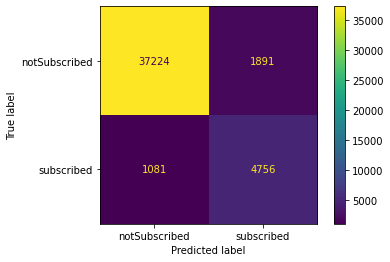

In [0]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

predicted_probas = prod_model.predict(X)
predicted_probas[predicted_probas > 0.5] = 1
predicted_probas[predicted_probas <= 0.5] = 0
matrix = confusion_matrix(predicted_probas, y)
fig = ConfusionMatrixDisplay(matrix, display_labels=["notSubscribed", "subscribed"])
fig.plot()

## 1.4 Saving the final model name to configuration

Now that we got everything working, we just need to save the updated `model_name` variable in the original configuration file, so we can refer to it in the following weekly assignments. To do that, execute the code below:

In [0]:
config.set("Cloud", "model_name", model_name)

with open(config_path, "w") as configfile:
    config.write(configfile)